In [2]:
import numpy as np
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import norm, logistic, bernoulli
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests

from tqdm import tqdm
from numba import njit
import json
import tempfile
import os

warnings.simplefilter(action="ignore", category=FutureWarning)
np.random.seed(0)


def save_pvals(p_values_setting1, p_values_setting2):
    data = {"setting1": p_values_setting1, "setting2": p_values_setting2}
    with open("data/p_values.json", "w") as f:
        json.dump(data, f)


def load_pvals():
    with open("data/p_values.json", "r") as f:
        data = json.load(f)
    return data["setting1"], data["setting2"]


def save_pyplot_figure(fig, filename):
    """
    Saves a Matplotlib figure to a file.
    """
    # Save the figure using the provided filename
    fig.savefig(filename)
    print(f"Figure saved as {filename}")


def combine_figures_vertically(F2AB, F2CD, output_filename="combined_figure.png"):
    """
    Combines two matplotlib figures by plotting the first above the second and saves the result.
    """
    # Create temporary files to save the figures
    temp_dir = tempfile.mkdtemp()
    f2ab_path = os.path.join(temp_dir, "F2AB.png")
    f2cd_path = os.path.join(temp_dir, "F2CD.png")

    # Save the input figures as images
    F2AB.savefig(f2ab_path, bbox_inches="tight")
    F2CD.savefig(f2cd_path, bbox_inches="tight")

    # Create a new figure for combining the saved images
    fig, axs = plt.subplots(2, 1, figsize=(14, 8))  # Adjust figsize as needed

    # Load and display the images in the new figure
    img_F2AB = mpimg.imread(f2ab_path)
    axs[0].imshow(img_F2AB)
    axs[0].axis("off")  # Hide axes

    img_F2CD = mpimg.imread(f2cd_path)
    axs[1].imshow(img_F2CD)
    axs[1].axis("off")  # Hide axes

    plt.tight_layout()

    # Save the combined figure
    plt.savefig(output_filename)
    plt.show()

    # Clean up the temporary files
    os.remove(f2ab_path)
    os.remove(f2cd_path)
    os.rmdir(temp_dir)

    print(f"Combined figure saved as {output_filename}")

## Part 1 and 2.

#### Problem setting

The problem addressed in the paper (Cand\`es et al. , 2018, \cite{}) is a classic statistical problem that we have also mentioned many times in class: the False Discovery Rate (FDR) control. 

#### Modelling
First, let's illustrate it using Figure 1 (same as Figure one in Cand\`es et al. , 2018 \cite{}). As in the article, the author simulated $10^4$ independent design matrices (sample size $n = 500$, amount of predictors $p = 200$) and binary responses from a logistic regression for the following two settings:
* one where the predictors $X_1,\cdots,X_p$ follor an $AR(1)$ time series with an autocorrelation coefficient of $0.5$ and the response $Y$ is Bernoulli distributed with probability $0.5$;
* another setting with the same predictor configuration but the response is Bernoulli distributed with a probability determined by a logit function involving a sum of the predictors $X_2,\cdots,X_{21}$.

The distribution of null logistic regression p-values under two simulation settings was obtained by building GLM on these $X$ and $Y$. It is presented in Figure 1.

For the Python code used to generate datasets and images in this chapter and subsequent ones, please refer to the 'Data and Code Availability' section.

#### Observation
Note, that in both cases Y is not dependent on $X_1$ (however in the second case there is influence of $X_1$ on all X, including $X_2,\cdots,X_{21}$). The null hypothesis here states that a particular predictor ($X_1$) has no effect on the outcome. Under the null hypothesis, p-values should be uniformly distributed between 0 and 1, meaning any small segment of this range should contain a proportionate number of the total p-values.

However, in both settings we observe inflation of probabilities: 

* for first setting: for very small p-values (specifically at the 5% percentile), the probability of obtaining such a p-value (or smaller) under the null hypothesis is significantly higher than expected: in this setting there is no ANY real true positive dependency between $X_1$ and $Y$. This indicates a high chance of falsely discovering an effect (false positives). 

* for the second setting: the exact distribution of null p-values (those that should not indicate any significant effect) is influenced by the actual values of unknown coefficients ($\beta_2,\cdots,\beta_{21}$). This means that the likelihood of observing small p-values not only is inflated but also varies significantly depending on the true effects of the predictors.

Therefore the method used to calculate p-values might not be reliable for determining significance in these high-dimensional logistic regression scenarios, leading to many false discoveries (first case). What is more, p-values distribution can depend in general on unknown problem parameters, causing difficulties in interpretation.

In [6]:
# njit -- numba lib for speeding up calculations
@njit
def generate_ar1_series(n, p, phi=0.5):
    """
    Generate an AR(1) series for each predictor.
    Parameters:
    - n: Number of observations
    - p: Number of predictors
    - phi: AR(1) coefficient
    Returns:
    - X: An (n x p) matrix where each column is an AR(1) series
    """
    X = np.zeros((n, p))
    for i in range(p):
        X[0, i] = np.random.normal()
        for j in range(1, n):
            X[j, i] = phi * X[j - 1, i] + np.random.normal()
    return X


def draw_both_pvals(
    p_values_setting1, p_values_setting2, ab_names=["A", "B"], title_add=""
):
    """
    Main drawing histograms function
    """
    sns.set_style("white")
    sns.set_palette("pastel")

    f = plt.figure(figsize=(14, 3))

    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(
        p_values_setting1, edgecolor="black", bins=20, color="skyblue", kde=False
    )
    plt.title(f"Setting 1: p-values Distribution{title_add}")
    plt.xlabel("p-value")
    plt.ylabel("Counts")
    # Adding label "A" at the top-left corner
    ax1.text(
        x=ax1.get_xlim()[0],
        y=ax1.get_ylim()[1] * 1.03,
        s=ab_names[0],
        fontsize=20,
        weight="bold",
        ha="left",
        va="bottom",
    )

    ax2 = plt.subplot(1, 2, 2)
    sns.histplot(
        p_values_setting2, edgecolor="black", bins=20, color="lightgreen", kde=False
    )
    plt.title(f"Setting 2: p-values Distribution{title_add}")
    plt.xlabel("p-value")
    plt.ylabel("Counts")
    # Adding label "B" at the top-left corner
    ax2.text(
        x=ax2.get_xlim()[0],
        y=ax2.get_ylim()[1] * 1.03,
        s=ab_names[1],
        fontsize=20,
        weight="bold",
        ha="left",
        va="bottom",
    )

    plt.tight_layout()
    plt.show()
    return f

In [3]:
# Params
n = 500  # Sample size
p = 200  # Number of predictors
replications = 10000  # Number of replications

# Save pvals to
p_values_setting1 = []
p_values_setting2 = []

for _ in tqdm(range(replications)):
    # Generating AR(1) design matrix
    X = generate_ar1_series(n, p, phi=0.5)
    X = sm.add_constant(X)  # Add intercept

    # Setting 1
    y1 = bernoulli.rvs(0.5, size=n)
    model1 = GLM(y1, X, family=Binomial(link=logit()))
    results1 = model1.fit()
    p_values_setting1.append(results1.pvalues[1])  # p-value for beta1 (adjusted for intercept)

    # Setting 2
    linear_predictor = 0.08 * np.sum(X[:, 2:22], axis=1)  # Adjust indices for intercept
    y2_prob = logistic.cdf(linear_predictor)
    y2 = bernoulli.rvs(y2_prob)
    model2 = GLM(y2, X, family=Binomial(link=logit()))
    results2 = model2.fit()
    p_values_setting2.append(results2.pvalues[1])  # p-value for beta1 (adjusted for intercept)

# save them
save_pvals(p_values_setting1, p_values_setting2)

 23%|████████▋                             | 2302/10000 [09:10<30:03,  4.27it/s]/home/toharhymes/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
 35%|█████████████▎                        | 3496/10000 [14:32<26:28,  4.10it/s]/home/toharhymes/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/toharhymes/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/toharhymes/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparatio

In [7]:
p_values_setting1, p_values_setting2 = load_pvals()

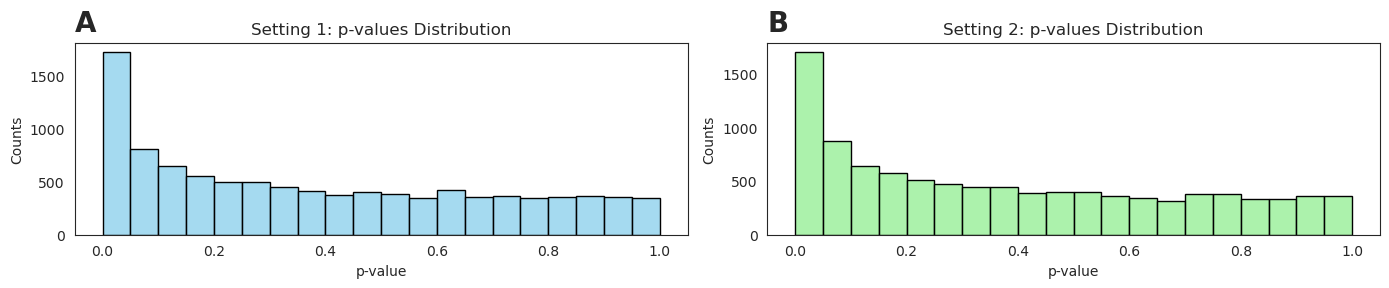

Figure saved as figures/F1.png


In [8]:
F1 = draw_both_pvals(p_values_setting1, p_values_setting2)
save_pyplot_figure(F1, "figures/F1.png")

## Part 3 and 4

To be honest, I (the researcher) did not understand the mathematical details of the method implementation in the article well (although I wanted to, but too busy week). Therefore I decided to try simpler methods: FDR multiple testing adjustment: Bonferroni (BF) \cite{XXX} and Benjamini-Hochberg (BH) \cite{Benjamini and Hochberg, 1995}. They have restrictions: e.g. BF controls the FDR under p-value independence and BF is very conservative, however it works quite well for the most of the cases. Despite Cand\`es et al. , 2018 \cite{} (and a lot of other works) proposed algorithm that work better and less constraining, for our case these 2 methods should work. The core ideas of these adjustments are:

* The Bonferroni adjustment is a conservative method to control the family-wise error rate (FWER) when performing multiple comparisons. The idea is to reduce the chance of obtaining false-positive results (Type I errors) by dividing the desired significance level ($\alpha$) by the number of tests (m). The algorithm simply involves comparing each individual p-value against this adjusted threshold to decide on rejecting the null hypothesis.

* The Benjamini-Hochberg (BH) adjustment aims to control the false discovery rate (FDR), which is the expected proportion of false positives among the rejected hypotheses. The algorithm ranks the individual p-values in ascending order, then finds the largest rank $k$ for which the $k$th p-value is less than or equal to $(k/m) \cdot \alpha$, where $m$ is the total number of tests and $\alpha$ is the desired FDR level. All hypotheses corresponding to p-values up to the $k$th are rejected. 


Figure 2 shows histogram for same p-values, but adjusted using BH (Figure 2A,B) and using BF (Figure 2C,D). Adjusted p-values are not shifted to zero.

(below is chat-gpt, change it):

* Bonferroni adjustment: This approach is very conservative and can increase the likelihood of Type II errors (failing to reject a false null hypothesis). If p-values are adjusted to one, it indicates that the tests are far from showing any significant differences after correcting for the risk of making Type I errors (false positives) due to multiple comparisons.

* Benjamini-Hochberg (B-H) adjustment: This method controls the false discovery rate (FDR) rather than strictly controlling the chance of any false positives as Bonferroni does. Adjusted p-values reaching one suggest that the findings are not statistically significant at the chosen FDR threshold. It implies that, under the B-H criterion for controlling the rate of false discoveries, there's no evidence strong enough to claim significant findings after accounting for multiple testing.

In [9]:
def calculate_pvals_adj(pvals, method='bonferroni'):
    return list(multipletests(pvals, method=method)[1])

### FDR Benjamini/Hochberg adjustment

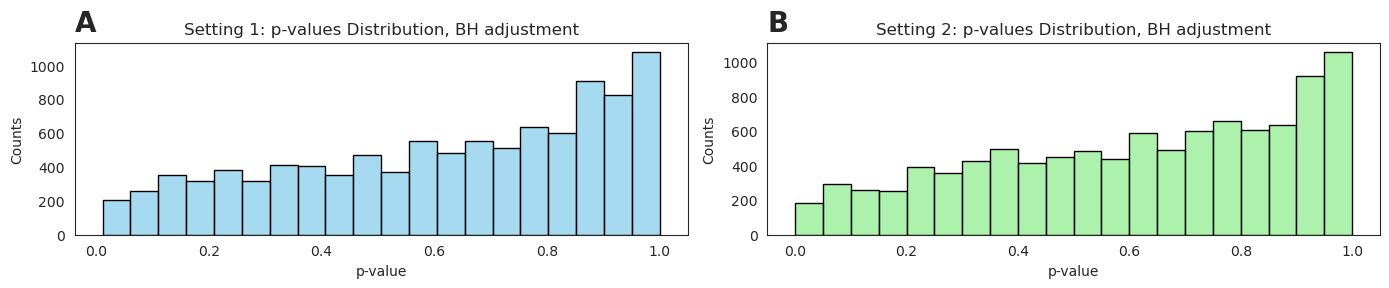

In [10]:
F2AB = draw_both_pvals(
    calculate_pvals_adj(p_values_setting1, method="fdr_bh"),
    calculate_pvals_adj(p_values_setting2, method="fdr_bh"),
    ab_names=['A', 'B'],
    title_add=", BH adjustment"
)

### Classical one-step Bonferroni correction

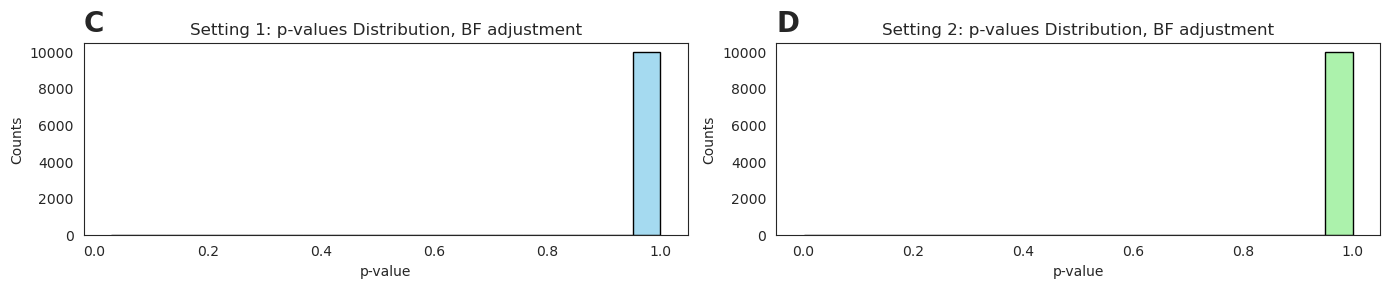

In [11]:
F2CD = draw_both_pvals(
    calculate_pvals_adj(p_values_setting1, method="bonferroni"),
    calculate_pvals_adj(p_values_setting2, method="bonferroni"),
    ab_names=['C', 'D'],
    title_add=", BF adjustment"
)

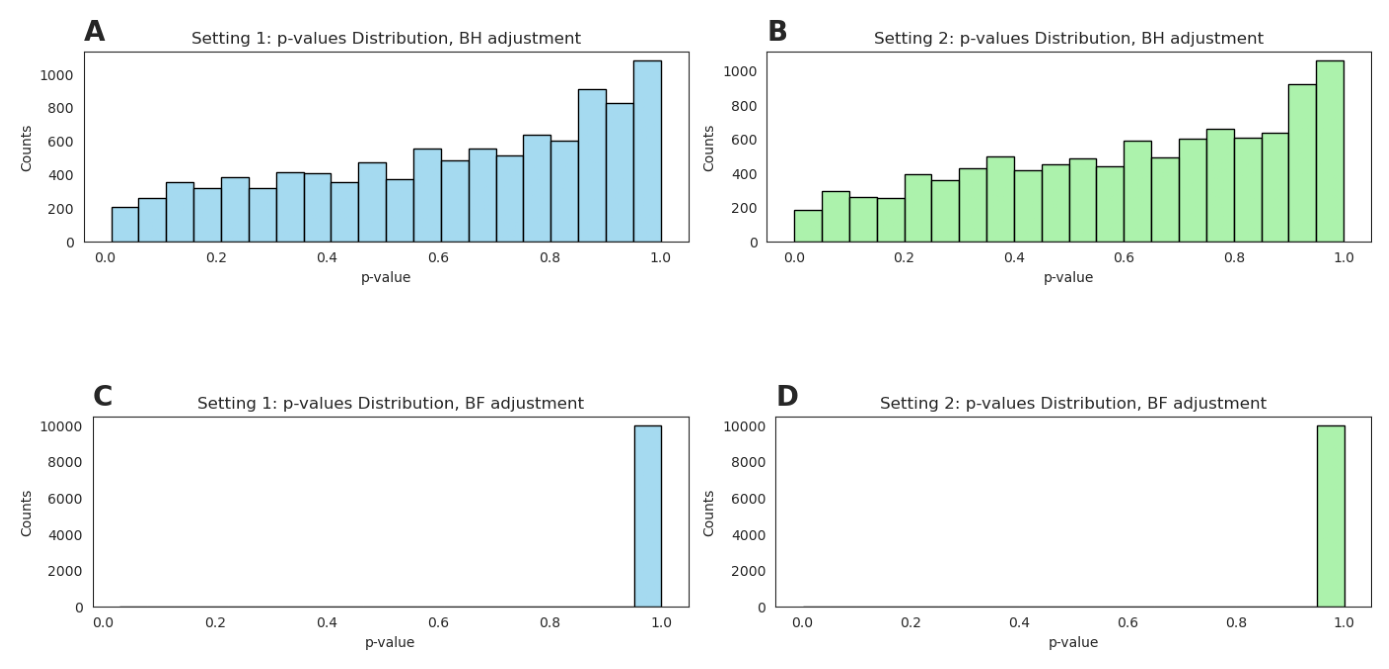

Combined figure saved as figures/F2.png


In [12]:
combine_figures_vertically(F2AB, F2CD, output_filename="figures/F2.png")

## Part 5

Apply to the real dataset -- in the second notebook.